In [1]:
import bindata as bnd
import pandas as pd
import numpy as np
capsules = pd.read_csv('../../data/capsules_with_freq.csv', sep=';')
drug_names_unique = capsules[['Drug_1', 'Drug_2', 'Drug_3', 'Drug_4', 'Drug_5', 'Drug_6', 'Drug_7', 'Drug_8']].stack().unique()
# normalize capsules['exact_exposure_count] to 0, 100
capsules['exact_exposure_count'] = capsules['exact_exposure_count'].replace('<100', 100)
capsules['exact_exposure_count'] = capsules['exact_exposure_count'].replace('1', 100)
capsules['exact_exposure_count'] = capsules['exact_exposure_count'].astype(int)
capsules['exact_exposure_count'] = capsules['exact_exposure_count'] / (capsules['exact_exposure_count']).max() * 20000
capsules['exact_exposure_count'] = capsules['exact_exposure_count'].astype(int) + 1

# Restructure the data (columns are drugs and rows are patients, values are 0 or 1)
data = []
for i, row in capsules.iterrows():
    patient_data = []
    for drug in drug_names_unique:
        patient_data.append(int(drug in row.values))
    
    # data.append(patient_data)
    data.extend([patient_data] * row['exact_exposure_count'])

index = [f"comb{i}" for i in range(len(data))]
data = pd.DataFrame(data, columns=drug_names_unique, dtype=int, index=index)
data.head()
data.shape

feature_probs = np.mean(data, axis=0)

correlation_matrix = np.corrcoef(data, rowvar=False) # correlation, same as (np.cov(X,Y)[0,1]/(np.std(X,ddof=1)*np.std(Y,ddof=1)))
correlation_matrix = np.ceil(correlation_matrix * 1e12) / 1e12
# store feat_probs and correlation_matrix csv
# np.savetxt('feat_probs.csv', feature_probs, delimiter=',')
# np.savetxt('correlation_matrix.csv', correlation_matrix, delimiter=',')

In [2]:
from main import generate_multivariate_binary

nsamples = 100000
sample, metadata = generate_multivariate_binary(40, nsamples, feature_probs, correlation_matrix, (3, 6))

/Users/karina/Library/Python/3.9/lib/python/site-packages/bindata/check_commonprob.py:81: UserWarning: simulvals provided is not computed to a sufficient resolution
to resolve the common probabilies provided in commonprob.


INTERPOLATION IS GOING TO BE USED.

Consider computing simulvals on a finer grid.
The current resolution is on these points:
[(0, 0), (0, 0.001), (0, 0.01), (0, np.float64(0.05)), (0, np.float64(0.1)), (0, np.float64(0.15)), (0, np.float64(0.2)), (0, np.float64(0.25)), (0, np.float64(0.3)), (0, np.float64(0.35)), (0, np.float64(0.4)), (0, np.float64(0.45)), (0, np.float64(0.5)), (0, np.float64(0.55)), (0, np.float64(0.6)), (0, np.float64(0.65)), (0, np.float64(0.7)), (0, np.float64(0.75)), (0, np.float64(0.8)), (0, np.float64(0.85)), (0, np.float64(0.9)), (0, np.float64(0.95)), (0, 0.99), (0, 0.999), (0, 1), (0.001, 0.001), (0.001, 0.01), (0.001, np.float64(0.05)), (0.001, np.float64(0.1)), (0.001, np.float64(0.15)), (0.001, np.float64(0.2)), (0.001, np.float64(0.2

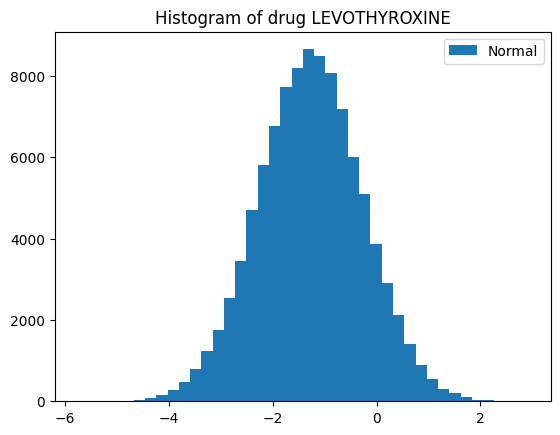

In [3]:
# Plot the histogram of a drug
import matplotlib.pyplot as plt
drug_idx = 2 # any number from 0 to 40
plt.hist(metadata['sample_norm'][:,drug_idx], bins=40)
# plt.hist(sample[:,drug_idx], bins=2, alpha=0.5)
plt.title(f'Histogram of drug {drug_names_unique[drug_idx]}')
plt.legend(['Normal', 'Binary'])
plt.show()

In [4]:
# group by sum 
sample = sample.astype(int)
sampledf = pd.DataFrame(data, columns=drug_names_unique)
sampledf['sum'] = sampledf.sum(axis=1)
sums = sampledf['sum'].value_counts().sort_index()
print('Count of drugs per patient in real data: ', sums) 
# print(sums / sums.sum())

sampledf = pd.DataFrame(sample, columns=drug_names_unique)
sampledf['sum'] = sampledf.sum(axis=1)
print('Count of drugs per patient in generated data: ', sampledf['sum'].value_counts().sort_index())

Count of drugs per patient in real data:  sum
3    352760
4     29011
5      1735
6       104
7        26
8         6
Name: count, dtype: int64
Count of drugs per patient in generated data:  sum
3    25192
4    24820
5    25136
6    24852
Name: count, dtype: int64


In [5]:
import plotly.express as px
def visualize(sample_data):
    corr_with_zero_diag = np.corrcoef(data, rowvar=False) - np.eye(sample_data.shape[1])
    fig = px.imshow(corr_with_zero_diag, x=drug_names_unique, y=drug_names_unique, zmin=-1, zmax=1, color_continuous_scale='RdBu', title='Input correlation matrix')
    fig.show()
    corr_with_zero_diag = np.corrcoef(sample_data, rowvar=False) - np.eye(sample_data.shape[1])
    fig = px.imshow(corr_with_zero_diag, x=drug_names_unique, y=drug_names_unique, zmin=-1, zmax=1, color_continuous_scale='RdBu', title='Sample correlation matrix')
    fig.show()

    # sort drug_names_unique and feature_probs by feature_probs
    drug_names_unique_sorted = [x for _, x in sorted(zip(feature_probs, drug_names_unique), reverse=True)]
    feature_probs_sorted = sorted(feature_probs, reverse=True)
    sample_marg_sorted = np.mean(sample_data, axis=0)[np.argsort(feature_probs)[::-1]]

    fig = px.bar(x=drug_names_unique_sorted, y=feature_probs_sorted, title='Input marginal probabilities')
    # fig.update_xaxes(categoryorder='total descending')
    fig.show()
    fig = px.bar(x=drug_names_unique_sorted, y=sample_marg_sorted, title='Sampled marginal probabilities')
    # fig.update_xaxes(categoryorder='total descending') same ordering as in fig 1
    fig.update_xaxes(categoryorder='array', categoryarray=drug_names_unique_sorted)
    fig.show()

In [6]:
sample.astype(int)

visualize(sample)


In [8]:
feature_probs = np.loadtxt('feat_probs_smoother.csv', delimiter=',')

nsamples = 1000000
sample_2, _ = generate_multivariate_binary(40, nsamples, feature_probs, correlation_matrix, (3, 6))
visualize(sample_2)

In [9]:
# feature_probs = np.loadtxt('feat_probs_all_equal_0.7.csv', delimiter=',')
feature_probs = np.array([0.05] * 40)

nsamples = 1000000
sample_3, _ = generate_multivariate_binary(40, nsamples, feature_probs, correlation_matrix, (3, 6))
visualize(sample_3)

In [17]:
sampledf = pd.DataFrame(sample_3, columns=drug_names_unique)
sampledf['sum'] = sampledf.sum(axis=1)
print('Number of drugs per sample \n', sampledf['sum'].value_counts().sort_index())

Number of drugs per sample 
 sum
3.0    200085
4.0    199867
5.0    200016
6.0    199438
7.0    200594
Name: count, dtype: int64
